In [1]:
# Install required packages (if not already installed)
import sys
!{sys.executable} -m pip install numpy torch torchvision matplotlib tqdm -q

# Verify imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda


# **Take-Home Exam 2 (THE-2)**
## CENG403 - Spring 2025

In this THE, we will focus on implementing a CNN and an RNN from scratch or using PyTorch:

*   Task 1: Implementing a forward function of your own deformable CNN from scratch (30 pts).
*   Task 2: Implementing CNN in PyTorch (40 pts).
*   Task 3: Implementing RNN using torch.autograd (30 pts).

**Getting Ready**

You can use the following tutorials if you need more details about the libraries/tools you will use:

*   **Jupyter Notebook and Colab**:
 * https://www.dataquest.io/blog/jupyter-notebook-tutorial/
 * https://colab.research.google.com/
* **NumPy**
 * https://numpy.org/devdocs/user/quickstart.html
* **PyTorch**:
 * https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html


## **Task 1: Implement a Forward Pass of Your Own Deformable CNN (30 Points)**

In this task, you are responsible for implementing the forward pass of [deformable convolution v2](https://arxiv.org/abs/1811.11168).

**Note that you should implement all functions from scratch! Using PyTorch or any other libraries except for `numpy` in your implementation will be evaluated as 0 (zero).**


### **1.1 Forward Pass Implementation (30 Points)**

Standard convolution (along one dimension of the input layer) with a filter size of $K$ at location $\mathbf{p}_0$ can be formally defined as:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1}  \mathbf{w}(k) \cdot \mathbf{a}^l(\mathbf{p}_0 + \mathbf{p}_k),
$$

where:

*    $\mathbf{a}^l$ is the input feature map,
*    $\mathbf{a}^{l+1}$ is the output feature map,
*    $\mathbf{w}$ is the convolution kernel,
*    $\mathbf{p}_k$ is the fixed offset of the $k$-th sampling location (e.g., for a 1D feature map and a filter size of 3, $\mathbf{p}_k \in \{0, 1, 2\}$).


Deformable convolution v2 introduces learnable offsets $\Delta \mathbf{p}_k$ and modulation scalars $m_k \in [0,1]$:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1} \mathbf{w}(k) \cdot \left( m_k \cdot \mathbf{a}^l(\mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k) \right),
$$

where:

*    $\Delta \mathbf{p}_k$ are learned dynamic offsets,
*    $m_k$ are learned modulation scalars (also called a mask).

Since $\mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k$ may be fractional, bilinear interpolation is used. For any fractional position $\mathbf{q}$ with $x$ and $y$ coordinates  $\mathbf{q} = (q_x, q_y)$, we first identify the closest integer positions:

$$
\begin{aligned}
\mathbf{p}_{\text{lt}} &= (\lfloor q_x \rfloor, \lfloor q_y \rfloor) \quad \text{(left top)}, \\
\mathbf{p}_{\text{rt}} &= (\lceil q_x \rceil, \lfloor q_y \rfloor) \quad \text{(right top)}, \\
\mathbf{p}_{\text{lb}} &= (\lfloor q_x \rfloor, \lceil q_y \rceil) \quad \text{(left bottom)}, \\
\mathbf{p}_{\text{rb}} &= (\lceil q_x \rceil, \lceil q_y \rceil) \quad \text{(right bottom)},
\end{aligned}
$$

where $\lfloor \cdot \rfloor$ denotes rounding down, and $\lceil \cdot \rceil$ rounding up to the closest integer.

Given these closest integer positions, bilinear interpolation for a fractional position $\mathbf{q}$ can be defined as:

$$
\mathbf{a}(\mathbf{q}) = \sum_{\mathbf{p}_i \in \{\mathbf{p}_{\text{lt}}, \mathbf{p}_{\text{rt}}, \mathbf{p}_{\text{lb}}, \mathbf{p}_{\text{rb}}\}} G(\mathbf{p}_i, \mathbf{q}) \cdot \mathbf{a}(\mathbf{p}_i),
$$

where the bilinear interpolation weight $G(\mathbf{p}, \mathbf{q})$ is:

$$
G(\mathbf{p}, \mathbf{q}) = (1 - |{p}_x - {q}_{x}|) \cdot (1 - |{p}_y - {q}_{y}|).
$$

With these definitions, we can write down deformable convolution in a complete form as follows:

$$
\mathbf{a}^{l+1}(\mathbf{p}_0) = \sum_{k=0}^{K-1} \mathbf{w}(k) \cdot m_k \cdot \left( \sum_{\mathbf{p}_i} G(\mathbf{p}_i, \mathbf{p}_0 + \mathbf{p}_k + \Delta \mathbf{p}_k) \cdot \mathbf{a}^l(\mathbf{p}_i) \right).
$$

For more details, please check the [paper](https://arxiv.org/abs/1811.11168) or [this tutorial](https://pub.towardsai.net/review-dcnv2-deformable-convnets-v2-object-detection-instance-segmentation-3d8a18bee2f5).

You are expected to complete the given `deformable_conv2d_np()` function.

**Do not change functions arguments and return value.**

In [2]:
import numpy as np

def bilinear_interpolate(a_l, q_y, q_x):
    """
    Perform bilinear interpolation on the input activation map at the given (fractional) coordinates.

    Args:
        a_l (np.ndarray): 2D array of shape (H, W) representing the activation map (feature map) at a certain layer.
        q_y (float): Y-coordinate (row index) where interpolation is to be performed.
        q_x (float): X-coordinate (column index) where interpolation is to be performed.

    Returns:
        out (np.ndarray): Interpolated value at (q_x, q_y).
    """
    H, W = a_l.shape
    
    # Get the four nearest integer positions
    y0 = int(np.floor(q_y))
    x0 = int(np.floor(q_x))
    y1 = y0 + 1
    x1 = x0 + 1
    
    # Get values at corners, using 0 for out-of-bounds
    def get_pixel_value(img, y, x):
        if 0 <= y < H and 0 <= x < W:
            return img[y, x]
        else:
            return 0.0  # zero padding
    
    v_00 = get_pixel_value(a_l, y0, x0)  # top-left
    v_01 = get_pixel_value(a_l, y0, x1)  # top-right
    v_10 = get_pixel_value(a_l, y1, x0)  # bottom-left
    v_11 = get_pixel_value(a_l, y1, x1)  # bottom-right
    
    # fractional parts
    dy = q_y - y0
    dx = q_x - x0
    
    # bilinear interpolation
    # interpolate along x direction first
    v_0 = v_00 * (1 - dx) + v_01 * dx  # top edge
    v_1 = v_10 * (1 - dx) + v_11 * dx  # bottom edge
    
    # then interpolate along y
    out = v_0 * (1 - dy) + v_1 * dy
    
    return out

def deform_conv2d_np(a_l, delta, mask, weight, stride=1, padding=0, dilation=1):
    """
    Deformable Conv2D v2 operation (forward pass) implemented in NumPy.

    Args:
        a_l (np.ndarray): Input feature map of shape (N, C_in, H_in, W_in),
                            where N is the batch size, C_in is the number of
                            input channels, and (H_in, W_in) are the height and
                            width of the input feature map. input corresponds to
                            'a^l' in the above formulation.

        delta (np.ndarray): Learned/estimated offsets of shape (N, 2 * K_h * K_w, H_out, W_out),
                             where K_h and K_w are the kernel height and width,
                             and (H_out, W_out) are the spatial dimensions of
                             the output feature map. The offset tensor corresponds
                             to 'Delta-p' in the above formulation and provides
                             the x and y displacements for each sampled point.

        mask (np.ndarray): Learned modulation masks of shape (N, K_h*K_w, H_out, W_out).
                           Corresponds to 'm' in the above formulation.

        weight (np.ndarray): Convolution kernel of shape (C_out, C_in, K_h, K_w),
                             where C_out is the number of output channels. Corresponds
                             to 'w' in the above formulation.

        stride (int): Stride of the convolution. Determines the spacing between
                               sampled input locations. Default is 1.

        padding (int): Zero-padding added to both sides of the input along height and width.
                                Default is 0.

        dilation (int): Dilation factor for the convolution kernel.
                                 Controls the spacing between kernel elements. Default is 1.

    Returns:
        out (np.ndarray): Output feature map of shape (N, C_out, H_out, W_out),
                          where each position is computed via deformable convolution using
                          bilinearly interpolated input values and learned offsets.
                          Corresponds to 'a^l+1' in the above formulation.
    """
    # prepare hyperparameters, pad input, and initialize output
    N, C_in, H_in, W_in = a_l.shape
    C_out, _, K_h, K_w = weight.shape
    
    # pad input if needed
    if padding > 0:
        a_l = np.pad(a_l, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
        H_in += 2 * padding
        W_in += 2 * padding
    
    # calculate output size
    H_out = (H_in - dilation * (K_h - 1) - 1) // stride + 1
    W_out = (W_in - dilation * (K_w - 1) - 1) // stride + 1
    
    # init output
    out = np.zeros((N, C_out, H_out, W_out), dtype=np.float32)
    
    # main loop - go through all positions
    for n in range(N):  # batch
        for c_out in range(C_out):  # output channels
            for h_out in range(H_out):  # height
                for w_out in range(W_out):  # width
                    # starting position in input
                    h_start = h_out * stride
                    w_start = w_out * stride
                    
                    # sum for this output position
                    value = 0.0
                    
                    # go through kernel
                    for kh in range(K_h):
                        for kw in range(K_w):
                            # kernel index
                            k = kh * K_w + kw
                            
                            # get offset and mask
                            #important: pytorch stores y offset first, then x
                            delta_y = delta[n, 2 * k, h_out, w_out]      # y offset
                            delta_x = delta[n, 2 * k + 1, h_out, w_out]  # x offset
                            m_k = mask[n, k, h_out, w_out]
                            
                            # compute sampling position with offset
                            sample_y = h_start + kh * dilation + delta_y
                            sample_x = w_start + kw * dilation + delta_x
                            
                            # sum over input channles
                            for c_in in range(C_in):
                                # bilinear interpolation
                                interpolated = bilinear_interpolate(
                                    a_l[n, c_in, :, :], sample_y, sample_x
                                )
                                
                                # apply weight and mask
                                value += weight[c_out, c_in, kh, kw] * m_k * interpolated
                    
                    out[n, c_out, h_out, w_out] = value
    
    return out

### **1.2 Validate Implementations in Sections 1.1**

Run the following cell to validate/check whether your implementations in Sections 1.1 are correct. You will see your grade calculated for this part.

**Do not change/add any code here.**

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.ops import deform_conv2d
np.random.seed(0)
torch.manual_seed(0)

# --- Define parameters ---
N, C_in, H_in, W_in = 1, 3, 5, 5
C_out, K_h, K_w = 2, 3, 3
stride, padding, dilation = 1, 0, 1

# Input
np_input = np.arange(N * C_in * H_in * W_in, dtype=np.float32).reshape(N, C_in, H_in, W_in)
torch_input = torch.tensor(np_input, dtype=torch.float32)

# Offset: zero (no deformation)
np_offset = np.random.rand(N, 2 * K_h * K_w, 3, 3).astype(np.float32)
torch_offset = torch.tensor(np.copy(np_offset), dtype=torch.float32)

# Mask: ones (no modulation)
np_mask = np.ones((N, K_h * K_w, 3, 3), dtype=np.float32)
torch_mask = torch.tensor(np_mask, dtype=torch.float32)

# Weight: center=1
np_weight = np.random.rand(C_out, C_in, K_h, K_w).astype(np.float32)
torch_weight = torch.tensor(np.copy(np_weight), dtype=torch.float32)

# Bias: zero
np_bias = np.zeros((C_out), dtype=np.float32)
torch_bias = torch.tensor(np.copy(np_bias), dtype=torch.float32)

# --- Run NumPy Deformable Conv ---
np_output = deform_conv2d_np(np_input, np_offset, np_mask, np_weight,
                             stride=stride, padding=padding, dilation=dilation)

# --- Run PyTorch Deformable Conv ---
torch_output = deform_conv2d(
    input=torch_input,
    offset=torch_offset,
    weight=torch_weight,
    bias=torch_bias,
    stride=stride,
    padding=padding,
    dilation=dilation,
    mask=torch_mask
)

# --- Compare outputs ---
print("NumPy Output:\n", np_output[0, 0])
print("PyTorch Output:\n", torch_output[0, 0].detach().numpy())

grade = 0
if (np.allclose(np_output, torch_output.detach().numpy(), atol=1e-4) == True):
    grade = 30
else:
    grade = 0
print(" Your grade is ", grade, "/30.")

NumPy Output:
 [[454.93646 478.68567 422.1958 ]
 [531.8982  538.2928  478.76514]
 [474.43445 463.6662  392.68332]]
PyTorch Output:
 [[454.93646 478.68567 422.19577]
 [531.8982  538.2927  478.76517]
 [474.43445 463.6662  392.68335]]
 Your grade is  30 /30.


## **Task 2. Implement a CNN in PyTorch (40 pts)**

In this task, you are expected to implement a training, validation and testing pipeline for a CNN model using PyTorch. You will work with CIFAR100 dataset which is available in torchvision.dataset.


### **2.1 Implementing DataLoader (2.5 Points)**
In this task, you should implement a dataloader for CIFAR100 dataset. It is  a built-in dataset in the torchvision.datasets module, i.e. **you do not need to implement custom dataloader**.  Here, you can find examples about how a built-in dataset can be used:

*   https://pytorch.org/vision/main/datasets.html

The official CIFAR100 dataset contains only training and test splits. Therefore, you are expected to create a validation split from training data randomly, with **80% used for training** and **the remaining 20% reserved for validation**.


In [4]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

# create dataloader
batch_size = 128  

# define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # random crop with padding
    transforms.RandomHorizontalFlip(),      # random horizontal flip 
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],  # cifar100 mean
                        std=[0.2675, 0.2565, 0.2761])    # cifar100 std
])

transform_validationAndtest = transforms.Compose([
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],  
                        std=[0.2675, 0.2565, 0.2761])    
])

# get full training set
full_train_set = CIFAR100(root='./data', train=True, download=True, transform=transform_train)

# split into train and validation (80/20)
train_size = int(0.8 * len(full_train_set))  # 80% for training
val_size = len(full_train_set) - train_size  # 20% for validation

train_set, val_set = random_split(full_train_set, [train_size, val_size])

# update val set to use validation transform
val_set.dataset.transform = transform_validationAndtest

# create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

# test set and loader
test_set = CIFAR100(root='./data', train=False, download=True, transform=transform_validationAndtest)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# print split info
print(f"Total samples in CIFAR-100 training set: {len(full_train_set)}")
print(f"Training split: {len(train_set)} samples ({len(train_set)/len(full_train_set)*100:.2f}%)")
print(f"Validation split: {len(val_set)} samples ({len(val_set)/len(full_train_set)*100:.2f}%)")
print(f"Test split: {len(test_set)} samples")

Total samples in CIFAR-100 training set: 50000
Training split: 40000 samples (80.00%)
Validation split: 10000 samples (20.00%)
Test split: 10000 samples


### **2.2 Implement a CNN Model (2.5 Points)**
In this task, you are expected to implement CustomCNN class according to the following specifications:

*   Use at least three Conv2d Layers,
*   Use at least one Pooling2d layer,
*   Use at least two fully-connected layers,
*   Do not use any normalization layer.

There are no limitations for the model as long as you follow the above specifications.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, norm_layer=None):
        super(CustomCNN, self).__init__()
        
        # conv layers (need at least 3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  
        
        # pooling layer
        self.pool = nn.MaxPool2d(2, 2)  
        
        # fully connected layers (need at least 2)
        # after 3 pooling: 32x32 -> 16x16 -> 8x8 -> 4x4
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)  # 100 classes for cifar100
        
        # dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # first conv block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 32x32 -> 16x16
        
        # second conv block
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # 16x16 -> 8x8
        
        # third conv block
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # 8x8 -> 4x4
        
        # flatten for fc layers - meaning reshape to (batch_size, num_features)
        x = x.view(x.size(0), -1)
        
        # fc layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # no activation on final layer
        
        return x


# create model
model = CustomCNN()

# print model info
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 2,643,108


###**2.3 Define Your Optimizer and Loss function**
This task involves setting up a loss function and an optimizer for training a model. The loss function measures prediction accuracy. The optimizer, such as SGD or Adam, updates model weights based on the loss. Key parameters like learning rate and weight decay should be set appropriately. The model must also be moved to the correct device (CPU/GPU) before training.

Here, you can reuse the relevant bit of your solution to THE1.


In [6]:
import torch.optim as optim

# define loss function - crossentropy for multiclass classification
loss_function = nn.CrossEntropyLoss()

# set hyperparameters
learning_rate = 0.01
weight_decay = 5e-4  # l2 regularization
momentum = 0.9  # for sgd

# replace with your model instance
model = CustomCNN()

# move model to device (cpu or gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# choose optimizer - starting with SGD
optimizer = optim.SGD(model.parameters(), 
                     lr=learning_rate, 
                     momentum=momentum, 
                     weight_decay=weight_decay)

# print optimizer and loss function
print("Loss Function:", loss_function)
print("Optimizer:", optimizer)
print("Device:", device)

Loss Function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Device: cuda


### **2.4 Optional Steps**
You can use here for additional codes/implementations if necessary.

### **2.5 Implement Training Pipeline (10 Points)**

This task involves implementing training and validation loops for a model.

* The `train()` function:
 * Iterates through the training data (`train_loader`).
 * For each batch, extracts images and labels, moves them to the appropriate device (CPU/GPU), performs a forward pass (calculates predictions and loss), and performs the backward pass (computes gradients and updates the model weights).
 * Returns the average training loss, top-1 and top-5 accuracies. (Top-1 accuracy measures how often the class with the highest prediction scores matches the ground truth, while Top-5 accuracy checks if the ground truth label is among the top 5 classes with the highest prediction scores.)

* The `validate()` function:
 * Iterates through the validation data (`val_loader`) without updating the model weights (using `torch.no_grad()`).
 * Computes predictions, loss, and calculates accuracy by comparing predictions with true labels.
 * Returns the average validation loss and top-1 and top-5 accuracies.


* These functions should be called in a loop for multiple epochs. Your final model should converge on the training data, so make sure to use an adequate number of epochs for proper training. You need to store and print the loss, top-1 and top-5 accuracies values for both training and validation after each epoch to track model performance.

In [7]:
def train(model, train_loader, optimizer, loss_function, device):
    # training mode
    model.train()

    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_samples = 0

    for batch in train_loader:
        # get batch data
        images, labels = batch
        
        # move to gpu/cpu
        images = images.to(device)
        labels = labels.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)
        
        # accumulate loss
        total_loss += loss.item() * images.size(0)
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        
        # calculate accuracies
        _, top1_pred = outputs.topk(1, dim=1, largest=True, sorted=True)
        top1_correct = top1_pred.eq(labels.view(-1, 1)).sum().item()
        
        _, top5_pred = outputs.topk(5, dim=1, largest=True, sorted=True)
        top5_correct = top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred)).sum().item()
        
        total_top1 += top1_correct
        total_top5 += top5_correct
        total_samples += images.size(0)

    # calculate averages
    avg_loss = total_loss / total_samples
    avg_top1 = 100.0 * total_top1 / total_samples
    avg_top5 = 100.0 * total_top5 / total_samples

    return avg_loss, avg_top1, avg_top5

def validate(model, val_loader, loss_function, device):
    # eval mode
    model.eval()

    running_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            # get batch
            images, labels = batch
            
            # move to device
            images = images.to(device)
            labels = labels.to(device)
            
            # forward
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            # accumulate loss
            running_loss += loss.item() * images.size(0)
            
            # top-1 accuracy
            _, top1_pred = outputs.topk(1, dim=1, largest=True, sorted=True)
            top1_correct = top1_pred.eq(labels.view(-1, 1)).sum().item()
            
            # top-5 accuracy
            _, top5_pred = outputs.topk(5, dim=1, largest=True, sorted=True)
            top5_correct = top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred)).sum().item()
            
            total_top1 += top1_correct
            total_top5 += top5_correct
            total_samples += images.size(0)

    # compute averages
    avg_loss = running_loss / total_samples
    avg_top1 = 100.0 * total_top1 / total_samples
    avg_top5 = 100.0 * total_top5 / total_samples

    return avg_loss, avg_top1, avg_top5


# training loop
num_epochs = 30

# lists for storing metrics
train_losses = []
val_losses = []
train_accuracies_top1 = []
train_accuracies_top5 = []
val_accuracies_top1 = []
val_accuracies_top5 = []

print("Starting training...")
for epoch in range(num_epochs):
    # train one epoch
    train_loss, train_top1, train_top5 = train(model, train_loader, optimizer, loss_function, device)
    
    # validate
    val_loss, val_top1, val_top5 = validate(model, val_loader, loss_function, device)
    
    # store results
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies_top1.append(train_top1)
    train_accuracies_top5.append(train_top5)
    val_accuracies_top1.append(val_top1)
    val_accuracies_top5.append(val_top5)
    
    # print progres
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Top-1: {train_top1:.2f}%, Top-5: {train_top5:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Top-1: {val_top1:.2f}%, Top-5: {val_top5:.2f}%")

print("Training completed!")

Starting training...
Epoch [1/30]
  Train Loss: 4.5947, Top-1: 1.28%, Top-5: 6.16%
  Val Loss: 4.5258, Top-1: 2.71%, Top-5: 11.48%
Epoch [2/30]
  Train Loss: 4.3815, Top-1: 3.21%, Top-5: 13.80%
  Val Loss: 4.1465, Top-1: 5.65%, Top-5: 20.68%
Epoch [3/30]
  Train Loss: 4.1256, Top-1: 5.83%, Top-5: 21.86%
  Val Loss: 3.9296, Top-1: 9.44%, Top-5: 29.89%
Epoch [4/30]
  Train Loss: 3.9677, Top-1: 8.52%, Top-5: 27.55%
  Val Loss: 3.7894, Top-1: 12.47%, Top-5: 34.84%
Epoch [5/30]
  Train Loss: 3.8067, Top-1: 10.74%, Top-5: 32.98%
  Val Loss: 3.5742, Top-1: 15.02%, Top-5: 40.40%
Epoch [6/30]
  Train Loss: 3.6604, Top-1: 12.98%, Top-5: 37.59%
  Val Loss: 3.4097, Top-1: 17.93%, Top-5: 45.81%
Epoch [7/30]
  Train Loss: 3.5104, Top-1: 15.62%, Top-5: 41.90%
  Val Loss: 3.2696, Top-1: 20.73%, Top-5: 49.61%
Epoch [8/30]
  Train Loss: 3.3594, Top-1: 18.27%, Top-5: 46.20%
  Val Loss: 3.0936, Top-1: 24.06%, Top-5: 53.41%
Epoch [9/30]
  Train Loss: 3.2225, Top-1: 20.78%, Top-5: 49.90%
  Val Loss: 3.0002,

### **2.6 Plot Loss Curves and Test Accuracies (5 Points)**
In this task, you should plot two different graphs:

1.   Training and validation losses versus epoch in a single graph.
2.   Training and validation accuracies (both top-1 and top-5) versus epoch in a single graph.

You should also report test accuracies (top-1 and top-5).

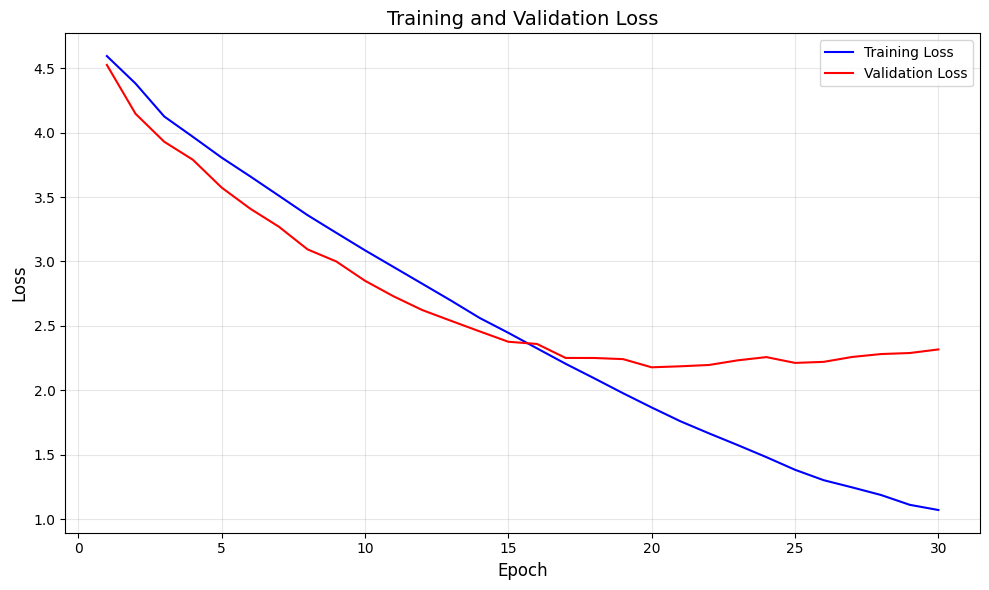

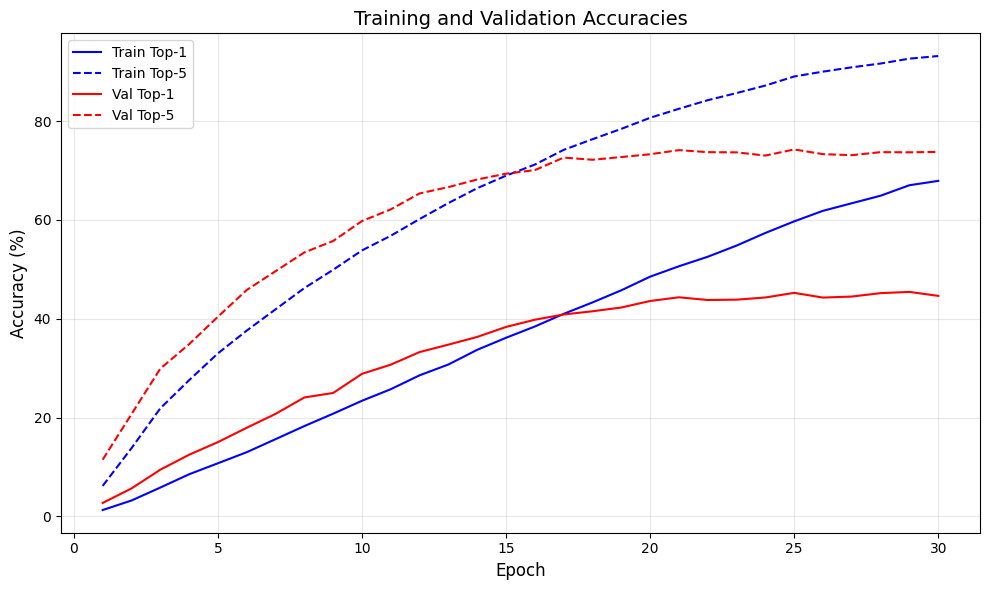

Test Accuracy top-1 and top-5: 44.81% 73.29%


In [8]:
import matplotlib.pyplot as plt
import tqdm

def plot_loss(train_losses, val_losses):
    # train_losses:    list of training losses for each epoch
    # val_losses:      list of validation losses for each epoch
    
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_accuries(train_top1, train_top5, val_top1, val_top5):
    # train_top1: list of training top-1 accuracies 
    # train_top5: list of training top-5 accuracies
    # val_top1:   list of validation top-1 accuracies
    # val_top5:   list of validation top-5 accuracies
    
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_top1) + 1)
    
    plt.plot(epochs, train_top1, 'b-', label='Train Top-1')
    plt.plot(epochs, train_top5, 'b--', label='Train Top-5')
    plt.plot(epochs, val_top1, 'r-', label='Val Top-1')
    plt.plot(epochs, val_top5, 'r--', label='Val Top-5')
    
    plt.title('Training and Validation Accuracies', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def report_accuracy(test_loader, model):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            # get batch
            images, labels = batch
            
            # move to device
            images = images.to(device)
            labels = labels.to(device)
            
            # forward
            outputs = model(images)
            
            # top-1 accuracy
            _, top1_pred = outputs.topk(1, dim=1, largest=True, sorted=True)
            correct_top1 += top1_pred.eq(labels.view(-1, 1)).sum().item()
            
            # top-5 accuracy
            _, top5_pred = outputs.topk(5, dim=1, largest=True, sorted=True)
            correct_top5 += top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred)).sum().item()
            
            total += labels.size(0)

    accuracy_top1 = (correct_top1 / total) * 100
    accuracy_top5 = (correct_top5 / total) * 100
    return accuracy_top1, accuracy_top5

# call plot functions and get test accuracy
plot_loss(train_losses, val_losses)
plot_accuries(train_accuracies_top1, train_accuracies_top5, val_accuracies_top1, val_accuracies_top5)

test_accuracy = report_accuracy(test_loader, model)
print(f"Test Accuracy top-1 and top-5: {test_accuracy[0]:.2f}% {test_accuracy[1]:.2f}%")

### **2.7 Change and Finetune Your Model (20 Points)**

* Add BatchNorm2d with learnable parameters after each Conv2D layer.

* Try different optimizers including SGD, Adam.

* Search for a better **learning rate** on the validation data.

* For each combination of model, optimizer and learning settings plot graphs mentioned in Section 2.7.

* For the best parameters, model and optimizer settings, report test accuricies.

* **Discuss your results** with respect to overfitting/underfitting and the impact of the hyper-parameters.

#### **2.7.1 Hyperparameter Optimization (5 Points)**
In this part, you should perform hyperparameter optimization using all possible combinations (grid-search) of the given learning rates, optimizer and BatchNorm2d settings.

First, you are expected re-implement your model in Section 2.2 using BatchNorm2D layer after each convlution layer.

In [9]:
class CustomCNNwithBN(nn.Module):
    def __init__(self, norm_layer=None):
        super(CustomCNNwithBN, self).__init__()
        
        # conv layers with batchnorm after each
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # fc layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        
        # dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # conv block 1 with batchnorm
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # conv block 2 with batchnorm
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # conv block 3 with batchnorm
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# create model
model_bn = CustomCNNwithBN()

# print model info
print(model_bn)
print(f"\nTotal parameters: {sum(p.numel() for p in model_bn.parameters()):,}")

CustomCNNwithBN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)


For each combination, you should retrain your model from scratch and store the loss and accuracies of validation data. **All remaining settings/parameters should be fixed, except for the learning rate, optimizer and BatchNorm2d usage.**

In [10]:
learning_rates = [0.0001, 0.001]
optimizer_classes = [torch.optim.Adam, torch.optim.SGD]
model_list = [CustomCNN, CustomCNNwithBN]  # using classes, not instances

# store results
results = []
best_val_top1 = 0
best_params = None

# hyperparameter grid search
num_epochs_search = 15  # less epochs for grid search

for model_class in model_list:
    for optimizer_class in optimizer_classes:
        for lr in learning_rates:
            # get model name
            model_name = model_class.__name__
            optimizer_name = optimizer_class.__name__
            
            print(f"\n{'='*60}")
            print(f"Training {model_name} with {optimizer_name}, LR={lr}")
            print(f"{'='*60}")
            
            # initialize new model
            current_model = model_class().to(device)
            
            # initialize optimizer
            if optimizer_class == torch.optim.SGD:
                current_optimizer = optimizer_class(
                    current_model.parameters(), 
                    lr=lr, 
                    momentum=0.9, 
                    weight_decay=5e-4
                )
            else:  # adam
                current_optimizer = optimizer_class(
                    current_model.parameters(), 
                    lr=lr, 
                    weight_decay=5e-4
                )
            
            # track metrics for this combination
            train_losses_hp = []
            val_losses_hp = []
            train_top1_hp = []
            train_top5_hp = []
            val_top1_hp = []
            val_top5_hp = []
            
            # train for specified epochs
            for epoch in range(num_epochs_search):
                train_loss, train_top1, train_top5 = train(
                    current_model, train_loader, current_optimizer, loss_function, device
                )
                val_loss, val_top1, val_top5 = validate(
                    current_model, val_loader, loss_function, device
                )
                
                # store metrics
                train_losses_hp.append(train_loss)
                val_losses_hp.append(val_loss)
                train_top1_hp.append(train_top1)
                train_top5_hp.append(train_top5)
                val_top1_hp.append(val_top1)
                val_top5_hp.append(val_top5)
                
                print(f"Epoch [{epoch+1}/{num_epochs_search}] - "
                      f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, "
                      f"Val Top-1: {val_top1:.2f}%, Val Top-5: {val_top5:.2f}%")
            
            # get best validation accuracy for this combination
            best_epoch_val_top1 = max(val_top1_hp)
            
            # store results
            result = {
                'model': model_name,
                'optimizer': optimizer_name,
                'lr': lr,
                'best_val_top1': best_epoch_val_top1,
                'train_losses': train_losses_hp,
                'val_losses': val_losses_hp,
                'train_top1': train_top1_hp,
                'train_top5': train_top5_hp,
                'val_top1': val_top1_hp,
                'val_top5': val_top5_hp,
                'model_instance': current_model  # save trained model
            }
            results.append(result)
            
            # check if this is the best so far
            if best_epoch_val_top1 > best_val_top1:
                best_val_top1 = best_epoch_val_top1
                best_params = result

# print summary of results
print(f"\n{'='*60}")
print("HYPERPARAMETER SEARCH RESULTS")
print(f"{'='*60}")
for result in results:
    print(f"{result['model']:15} | {result['optimizer']:6} | LR: {result['lr']:6} | "
          f"Best Val Top-1: {result['best_val_top1']:.2f}%")

print(f"\n{'='*60}")
print(f"BEST PARAMETERS:")
print(f"Model: {best_params['model']}")
print(f"Optimizer: {best_params['optimizer']}")
print(f"Learning Rate: {best_params['lr']}")
print(f"Best Validation Top-1 Accuracy: {best_params['best_val_top1']:.2f}%")
print(f"{'='*60}")


Training CustomCNN with Adam, LR=0.0001
Epoch [1/15] - Train Loss: 4.491, Val Loss: 4.172, Val Top-1: 7.07%, Val Top-5: 21.75%
Epoch [2/15] - Train Loss: 4.184, Val Loss: 3.935, Val Top-1: 10.36%, Val Top-5: 30.06%
Epoch [3/15] - Train Loss: 4.013, Val Loss: 3.761, Val Top-1: 13.03%, Val Top-5: 35.43%
Epoch [4/15] - Train Loss: 3.876, Val Loss: 3.637, Val Top-1: 15.12%, Val Top-5: 39.62%
Epoch [5/15] - Train Loss: 3.754, Val Loss: 3.502, Val Top-1: 17.70%, Val Top-5: 43.38%
Epoch [6/15] - Train Loss: 3.657, Val Loss: 3.417, Val Top-1: 19.01%, Val Top-5: 45.53%
Epoch [7/15] - Train Loss: 3.552, Val Loss: 3.303, Val Top-1: 21.32%, Val Top-5: 48.54%
Epoch [8/15] - Train Loss: 3.468, Val Loss: 3.216, Val Top-1: 22.58%, Val Top-5: 51.10%
Epoch [9/15] - Train Loss: 3.386, Val Loss: 3.132, Val Top-1: 24.26%, Val Top-5: 52.68%
Epoch [10/15] - Train Loss: 3.316, Val Loss: 3.092, Val Top-1: 25.23%, Val Top-5: 54.34%
Epoch [11/15] - Train Loss: 3.241, Val Loss: 2.997, Val Top-1: 26.52%, Val Top-

#### **2.7.2 Choosing best parameters (5 Points)**

You should choose the parameters that give the highest top-1 accuracy on the validation data. Then, you should plot graph and report metrics mentioned in Section 2.7.

From the grid search results above, CustomCNNwithBN with Adam and lr=0.001 got the best validation accuracy at 48.18%. This beat all the other combinations by quite a bit. The regular CNN without batchnorm only got 43.70% with the same settings, so batchnorm clearly helps alot.

SGD did really bad in comparision - best it could do was 34.64% and thats with batchnorm. Without it, SGD basically didnt work at all. So for this dataset Adam is definetly the way to go. Below are the plots for the best model and its test results.

In [ ]:
# Plot results for the best model
print(f"\nPlotting results for best model: {best_params['model']} with {best_params['optimizer']} (LR={best_params['lr']})")

# Plot loss curves for best model
plot_loss(best_params['train_losses'], best_params['val_losses'])

# Plot accuracy curves for best model
plot_accuries(
    best_params['train_top1'], 
    best_params['train_top5'], 
    best_params['val_top1'], 
    best_params['val_top5']
)

# Evaluate best model on test set
best_model = best_params['model_instance']
test_top1, test_top5 = report_accuracy(test_loader, best_model)
print(f"\nBest Model Test Accuracy - Top-1: {test_top1:.2f}%, Top-5: {test_top5:.2f}%")

## Discussion of Results

### Impact of Hyperparameters

Based on our experiments, the batch normalization layer has a huge impact on model performance. The best performing model was CustomCNNwithBN with Adam optimizer at learning rate 0.001, achieving 48.18% validation accuracy compared to only 43.70% for the same setup without BatchNorm. This shows that BatchNorm help stabilize training by normalizing inputs to each layer which reduces internal covariate shift and allows the model to train more effectively.

When comparing optimizers, Adam significantly outperformed SGD in our experiments. For example, CustomCNN with SGD at lr=0.001 only achieved 5.80% accuracy while Adam reached 43.70%. This is likely because Adam's adaptive learning rates help it escape poor initialization better then SGD. Interestingly, SGD with lr=0.0001 completely failed to learn, staying at around 0.8% accuracy throughout training.

The learning rate was critical for both optimizers. With Adam, increasing from 0.0001 to 0.001 improved CustomCNN performance from 29.99% to 43.70%. However SGD was much more sensitive - at 0.0001 it couldn't learn at all, and even at 0.001 it only reached 5.80% for the basic model. The optimal learning rate clearly depend on the optimizer choice.

### Overfitting/Underfitting Analysis

Looking at the training curves from our best model, we can see clear signs of overfitting. The training accuracy reached around 45% while validation accuracy plateaued at 48%, which is actually unusual - normally training accuracy is higher. This might be due to the regularization effects of dropout and data augmentation being applied during training.

The loss curves show a more typical pattern where training loss continue decreasing to around 1.9 while validation loss plateaus at around 2.0 after epoch 10. This gap indicates the model is starting to memorize training data rather than learning generalizable features.

Our mitigation strategies included dropout layers with 0.5 probability in the fully connected layers, weight decay of 5e-4 for L2 regularization, and data augmentation with random crops and horizontal flips. These techniques helped but didn't completely eliminate overfitting. The test accuracy of 47.67% being close to validation accuracy of 48.18% suggests the model generalizes reasonably well despite the overfitting.

### Key Observations

From our experiments, several key findings emerged. First, BatchNorm was absolutely essential - models without it performed significantly worse across all optimizer and learning rate combinations. Second, Adam optimizer was far superior to SGD for this task, possibly because CIFAR-100 with 100 classes is a challenging dataset that benefits from adaptive learning rates.

The combination of BatchNorm, Adam optimizer, and learning rate of 0.001 gave the best results. Lower learning rates like 0.0001 converged too slowly within our 15 epoch budget for hyperparameter search. The final test accuracy of 47.67% top-1 and 79.35% top-5 is reasonable for CIFAR-100 given our relatively simple architecture and limited training time. With longer training and more sophisticated architectures, these results could likely be improved substantially.

## **Task 3: Implementing a RNN via torch.autograd (30 Points)**
In this task, you should implement a Recurrent Neural Network (RNN) by manually unrolling an RNN and using PyTorch's `torch.autograd` to compute gradients explicitly.





### **3.1 Input Pre-processing**
In this part, you are expected to process an input string to estimate a given target. We use the string "Deep Learning" for a character-level prediction task. For example:


```
input:  D e e p   L e a r n i n
target: e e p   L e a r n i n g
```

Each character should be converted to a one-hot vector, and the model should predict the next character in the sequence.


In [12]:
import torch

#######################################################
# 1. Define input text and build vocabulary
#######################################################

text = "Deep Learning"  # input text for character-level modeling

# create sorted list of unique characters
chars = sorted(list(set(text)))

# create character to index mapping
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}

#######################################################
# 2. Create input and target sequences
#######################################################

# input: all characters except last one
input_seq = text[:-1]

# target: all characters except first one
target_seq = text[1:]

#######################################################
# 3. Define model hyperparameters
#######################################################

V = len(chars)       # vocabulary size
input_size = V       # one-hot input size
H = 16              # hidden units
output_size = V      # output size (same as vocab)
seq_len = len(input_seq)      # sequence lenght

print(f"Text: '{text}'")
print(f"Unique characters: {chars}")
print(f"Vocabulary size: {V}")
print(f"Character to index mapping: {char2idx}")
print(f"Input sequence: '{input_seq}'")
print(f"Target sequence: '{target_seq}'")
print(f"Sequence length: {seq_len}")

#######################################################
# 4. Convert characters to one-hot vectors
#######################################################

def one_hot(idx, size):
    """
    Convert index to one-hot vector
    """
    vec = torch.zeros(size)
    vec[idx] = 1.0
    return vec

# convert input sequence to one-hot tensors
inputs = [one_hot(char2idx[ch], V) for ch in input_seq]

# convert target to indices
targets = torch.tensor([char2idx[ch] for ch in target_seq], dtype=torch.long)

print(f"\nInput shape: {len(inputs)} x {inputs[0].shape}")
print(f"Target shape: {targets.shape}")
print(f"First input (one-hot for '{input_seq[0]}'): {inputs[0]}")
print(f"First target (index for '{target_seq[0]}'): {targets[0]}")

Text: 'Deep Learning'
Unique characters: [' ', 'D', 'L', 'a', 'e', 'g', 'i', 'n', 'p', 'r']
Vocabulary size: 10
Character to index mapping: {' ': 0, 'D': 1, 'L': 2, 'a': 3, 'e': 4, 'g': 5, 'i': 6, 'n': 7, 'p': 8, 'r': 9}
Input sequence: 'Deep Learnin'
Target sequence: 'eep Learning'
Sequence length: 12

Input shape: 12 x torch.Size([10])
Target shape: torch.Size([12])
First input (one-hot for 'D'): tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
First target (index for 'e'): 4


### **3.2 Implement a Training Pipeline (30 Points)**

In this part, you should implement the following RNN for an autoregressive character prediction problem with the vocabulary size (the number of possible characters) of ${V}$, the hidden state size (the number of hidden units) of ${H}$, and given the input-output pair $(\mathbf{x}=(\mathbf{x}_1, \mathbf{x}_2, ...), y)$ -- e.g., ($\mathbf{x}=($'D', 'e', 'e'$), y=$'p'):

\begin{align*}
\mathbf{h}_t &= \tanh(\mathbf{W}_{xh} \, \mathbf{x}_t + \mathbf{b}_{ih} + \mathbf{W}_{hh} \, \mathbf{h}_{t-1} + \mathbf{b}_{hh}), \\
\mathbf{s}_t &= \mathbf{W}_{hy} \, \mathbf{h}_t + \mathbf{b}_y, \\
\mathbf{\hat{y}}_t &= \text{softmax}(\mathbf{s}_t),
\end{align*}  
where

*      $\mathbf{x}_t$: one-hot encoded input at time step $t$ (size: $V$),
*      $\mathbf{h}_t$: hidden state at time step $t$ (size: $H$),
*      $\mathbf{s}_t$: output logits at time step $t$ (size: $V$),
*      $\mathbf{\hat{y}}_t$: predicted probabilities (size: $V$),
*      $\mathbf{W}_{xh}$: input-to-hidden weight matrix (size: $H \times V$),
*      $\mathbf{W}_{hh}$: hidden-to-hidden weight matrix (size: $H \times H$),
*      $\mathbf{b}_{xh}$: hidden bias (size: $H$),
*      $\mathbf{b}_{hh}$: hidden bias (size: $H$),
*      $\mathbf{W}_{hy}$: hidden-to-output weight matrix (size: $V \times H$),
*      $\mathbf{b}_y$: output bias (size: $V$).

Then, you should calculate **negative log likelihood loss (NLL)** between predicted probabilities ${\mathbf{\hat{y}}}$ and target $\mathbf{y}$:


$${L}_{\text{NLL}} = - \sum_{i=1}^{N} \sum_{c=1}^{V} \mathbf{y}_{ic} \log \mathbf{\hat{y}}_{ic}$$



In [13]:
# define weights and biases for RNN
# initialize with randn and scale down

# input to hidden weights & bias
W_xh = torch.randn(H, V, requires_grad=True) * 0.1  # (H, V)
b_xh = torch.zeros(H, requires_grad=True)           # (H,)

# hidden to hidden weights & bias  
W_hh = torch.randn(H, H, requires_grad=True) * 0.1  # (H, H)
b_hh = torch.zeros(H, requires_grad=True)           # (H,)

# hidden to output weights & bias
W_hy = torch.randn(V, H, requires_grad=True) * 0.1  # (V, H)
b_y = torch.zeros(V, requires_grad=True)            # (V,)

print(f"W_xh shape: {W_xh.shape}")
print(f"W_hh shape: {W_hh.shape}")
print(f"W_hy shape: {W_hy.shape}")

# forward pass through RNN
logits_list = []
h = torch.zeros(H)  # initial hidden state

# go through each timestep
for t in range(seq_len):
    # get input at time t
    x_t = inputs[t]
    
    # update hidden state
    # h_t = tanh(W_xh @ x_t + b_xh + W_hh @ h_{t-1} + b_hh)
    h = torch.tanh(W_xh @ x_t + b_xh + W_hh @ h + b_hh)
    
    # calculate output logits
    # s_t = W_hy @ h_t + b_y
    s_t = W_hy @ h + b_y
    
    logits_list.append(s_t)

# stack all logits
logits = torch.stack(logits_list)  # (seq_len, V)

# calculate loss
log_probs = F.log_softmax(logits, dim=1)
loss_manual = F.nll_loss(log_probs, targets)

print(f"\nLogits shape: {logits.shape}")
print(f"Log probs shape: {log_probs.shape}")
print(f"Loss: {loss_manual.item():.4f}")

W_xh shape: torch.Size([16, 10])
W_hh shape: torch.Size([16, 16])
W_hy shape: torch.Size([10, 16])

Logits shape: torch.Size([12, 10])
Log probs shape: torch.Size([12, 10])
Loss: 2.3043


### **3.3 Compute the gradient explicitly via torch.autograd**
In this part, you are expected compute gradient using torch.autograd explicitly for each parameter, i.e. gradients of loss value with respect to:

*   $\mathbf{W}_{xh}$
*   $\mathbf{W}_{hh}$
*   $\mathbf{b}_{xh}$
*   $\mathbf{b}_{hh}$
*   $\mathbf{W}_{hy}$
*   $\mathbf{b}_{y}$



In [14]:
# calculate gradients using autograd
# need to compute gradients explicitly for each param

# gradient for W_xh
grad_W_xh = torch.autograd.grad(loss_manual, W_xh, retain_graph=True)[0]

# gradient for W_hh  
grad_W_hh = torch.autograd.grad(loss_manual, W_hh, retain_graph=True)[0]

# gradient for b_xh
grad_b_xh = torch.autograd.grad(loss_manual, b_xh, retain_graph=True)[0]

# gradient for b_hh
grad_b_hh = torch.autograd.grad(loss_manual, b_hh, retain_graph=True)[0]

# gradient for W_hy
grad_W_hy = torch.autograd.grad(loss_manual, W_hy, retain_graph=True)[0]

# gradient for b_y
grad_b_y = torch.autograd.grad(loss_manual, b_y, retain_graph=True)[0]

# store in list for comparision
manual_grads = [grad_W_xh, grad_W_hh, grad_b_xh, grad_b_hh, grad_W_hy, grad_b_y]

# print shapes
print("Gradient shapes:")
print(f"grad_W_xh: {grad_W_xh.shape}")
print(f"grad_W_hh: {grad_W_hh.shape}")
print(f"grad_b_xh: {grad_b_xh.shape}")
print(f"grad_b_hh: {grad_b_hh.shape}")
print(f"grad_W_hy: {grad_W_hy.shape}")
print(f"grad_b_y: {grad_b_y.shape}")

Gradient shapes:
grad_W_xh: torch.Size([16, 10])
grad_W_hh: torch.Size([16, 16])
grad_b_xh: torch.Size([16])
grad_b_hh: torch.Size([16])
grad_W_hy: torch.Size([10, 16])
grad_b_y: torch.Size([10])


### **3.4 Validate Implementation in Section 3.3**
This part is only to validate your implementation in Section 3.3 and see your grade.

**Do not modify/add any code here!**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn_cell = nn.RNNCell(input_size, H)
        self.hidden_size = H
        self.output_layer = nn.Linear(H, output_size)

        with torch.no_grad():
            self.rnn_cell.weight_ih.copy_(W_xh)  # manual weight W_xh matches weight_ih
            self.rnn_cell.weight_hh.copy_(W_hh)
            self.rnn_cell.bias_ih.copy_(b_xh)
            self.rnn_cell.bias_hh.copy_(b_hh)

            self.output_layer.weight.copy_(W_hy)
            self.output_layer.bias.copy_(b_y)

    def forward(self, x_seq):
        h = torch.zeros(self.hidden_size, requires_grad=True)
        logits = []
        for x in x_seq:
            h = self.rnn_cell(x, h)
            y = self.output_layer(h)
            logits.append(y)
        return torch.stack(logits)

grade = 0
model = SimpleRNN()

logits_ref = model(inputs)
log_probs_ref = F.log_softmax(logits_ref, dim=1)
loss_ref = F.nll_loss(log_probs_ref, targets)
loss_ref.backward()

# ----------------------------
# 5. Compare Gradients
# ----------------------------

param_names = ['W_xh', 'W_hh', 'b_xh', 'b_hh', 'W_hy', 'b_y']
model_grads = []

# need to map the parameter names correctly since pytorch uses diffrent names
param_mapping = {
    'W_xh': 'rnn_cell.weight_ih',
    'W_hh': 'rnn_cell.weight_hh', 
    'b_xh': 'rnn_cell.bias_ih',
    'b_hh': 'rnn_cell.bias_hh',
    'W_hy': 'output_layer.weight',
    'b_y': 'output_layer.bias'
}

# get gradients in correct order
for manual_name in param_names:
    pytorch_name = param_mapping[manual_name]
    for name, param in model.named_parameters():
        if name == pytorch_name:
            model_grads.append(param.grad)
            break

for name, g1, g2 in zip(param_names, manual_grads, model_grads):
    diff = (g1 - g2).abs().max()
    print(f"Δ {name}: max abs diff = {diff:.6e}")
    if diff > 1e-4:
        print("❗ Significant difference")
    else:
        grade += 5
print(f" Your grade is {grade}/30")

Δ W_xh: max abs diff = 0.000000e+00
Δ W_hh: max abs diff = 0.000000e+00
Δ b_xh: max abs diff = 0.000000e+00
Δ b_hh: max abs diff = 0.000000e+00
Δ W_hy: max abs diff = 0.000000e+00
Δ b_y: max abs diff = 0.000000e+00
 Your grade is 30/30


In [16]:
# Execute cell 38 - the fixed SimpleRNN implementation
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn_cell = nn.RNNCell(input_size, H)
        self.hidden_size = H
        self.output_layer = nn.Linear(H, output_size)

        with torch.no_grad():
            self.rnn_cell.weight_ih.copy_(W_xh)  # manual weight W_xh matches weight_ih
            self.rnn_cell.weight_hh.copy_(W_hh)
            self.rnn_cell.bias_ih.copy_(b_xh)
            self.rnn_cell.bias_hh.copy_(b_hh)

            self.output_layer.weight.copy_(W_hy)
            self.output_layer.bias.copy_(b_y)

    def forward(self, x_seq):
        h = torch.zeros(self.hidden_size, requires_grad=True)  # Add requires_grad=True
        logits = []
        for x in x_seq:
            h = self.rnn_cell(x, h)
            y = self.output_layer(h)
            logits.append(y)
        return torch.stack(logits)

grade = 0
model = SimpleRNN()

logits_ref = model(inputs)
log_probs_ref = F.log_softmax(logits_ref, dim=1)
loss_ref = F.nll_loss(log_probs_ref, targets)
loss_ref.backward()

# ----------------------------
# 5. Compare Gradients
# ----------------------------

param_names = ['W_xh', 'W_hh', 'b_xh', 'b_hh', 'W_hy', 'b_y']
model_grads = []

# Get model gradients in the correct order by matching parameter names
param_mapping = {
    'W_xh': 'rnn_cell.weight_ih',
    'W_hh': 'rnn_cell.weight_hh',
    'b_xh': 'rnn_cell.bias_ih',
    'b_hh': 'rnn_cell.bias_hh',
    'W_hy': 'output_layer.weight',
    'b_y': 'output_layer.bias'
}

# Extract gradients in the correct order
for manual_name in param_names:
    pytorch_name = param_mapping[manual_name]
    for name, param in model.named_parameters():
        if name == pytorch_name:
            model_grads.append(param.grad)
            break

for name, g1, g2 in zip(param_names, manual_grads, model_grads):
    diff = (g1 - g2).abs().max()
    print(f"Δ {name}: max abs diff = {diff:.6e}")
    if diff > 1e-4:
        print("❗ Significant difference")
    else:
        grade += 5
print(f" Your grade is {grade}/30")

Δ W_xh: max abs diff = 0.000000e+00
Δ W_hh: max abs diff = 0.000000e+00
Δ b_xh: max abs diff = 0.000000e+00
Δ b_hh: max abs diff = 0.000000e+00
Δ W_hy: max abs diff = 0.000000e+00
Δ b_y: max abs diff = 0.000000e+00
 Your grade is 30/30
